# TO DO:
1- Basically identify the features you want to use in the data and the target variable
2- Run statistical analysis such as feature and target distribution plot, correlation analysis and heatmap plot. 
If your target variable is continuous, let's look at the scatter plot that shows the correlation between each feature and your target variable.
If your target variable is not continuous, think about showing box plot or violin plot to show the distribution of each feature for each class label.
3- Look at the number of missing values for each feature, the median, min, max, mode (for categorical features) and try to fully understand what each feature captures.

# Mortgage Lending Fair Feature Selection

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns
import datetime
from datetime import date
#import imblearn
import xgboost as xgb
#import fairfs
import probatus
import shap
import aif360

from aif360.datasets import BinaryLabelDataset
from aif360.metrics import ClassificationMetric
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost.sklearn import XGBClassifier
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn import metrics, model_selection, pipeline, preprocessing
from sklearn import linear_model, naive_bayes, tree
from statistics import mean
from mlxtend.feature_selection import SequentialFeatureSelector
#from fairfs import unfairness_metrics
from probatus.feature_elimination import ShapRFECV
from probatus.feature_elimination import EarlyStoppingShapRFECV
from numpy import sqrt
from numpy import argmax

pip install 'aif360[LawSchoolGPA]'
pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'


#### 1. HMDA Mortgage Lending Data
### Data Source: 
*Source: https://ffiec.cfpb.gov/documentation/2019/*

In [2]:
# Load HMDA data
df = pd.read_csv('hmda_mortgage_derived_race_ffs.csv')

#data.info()

In [4]:
df.shape[0]

73947

# 6. Split the Dataset into Training and Testing Sets
In this section I will define the target variable and features,split data into 70/30 segments.

In [5]:
# Define target and features
target = df['action_taken']
features = df.drop(['action_taken'], axis=1)

In [6]:
# Split into train/test while maintaining stratification to maintain class balance
#X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.30, random_state=42)

# In the first step we will split the data in training and remaining dataset
X_train, X_rem, y_train, y_rem = train_test_split(features,target, train_size=0.7)

# valid_size=0.5 (that is 50% of remaining data)
test_size = 0.5
X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5)


print('Number of data points in train data:', X_train.shape)
print('Number of data points in test data:', X_test.shape)

Number of data points in train data: (51762, 22)
Number of data points in test data: (11093, 22)


# 7. Feature selection - XAI based

In this section we perform a SHAP based feature selection technique based on feature contribution to the model performance. This is performed with the objective of identifying features that do not contribute to the performance.

## RandomForest Classifier
In this section we set up the hyperparameter grid to use RandomForest classifier to determine the most influential features in terms of performance.

In [7]:
rf = RandomForestClassifier(max_depth=5, class_weight='balanced')
param_grid = {
    #'n_estimators': [5, 7, 10],
    'max_depth': [3,5,7],
    'min_samples_leaf': [3, 5, 7, 10]    
}
search_roc_auc = RandomizedSearchCV(rf, param_grid, cv=5, scoring='roc_auc', refit=False)
search_prec = RandomizedSearchCV(rf, param_grid, cv=5, scoring='precision', refit=False)
search_recall = RandomizedSearchCV(rf, param_grid, cv=5, scoring='recall', refit=False)
print("Hyperparameter search complete")

Hyperparameter search complete


#### Visualize RFE for metric ROC_AUC

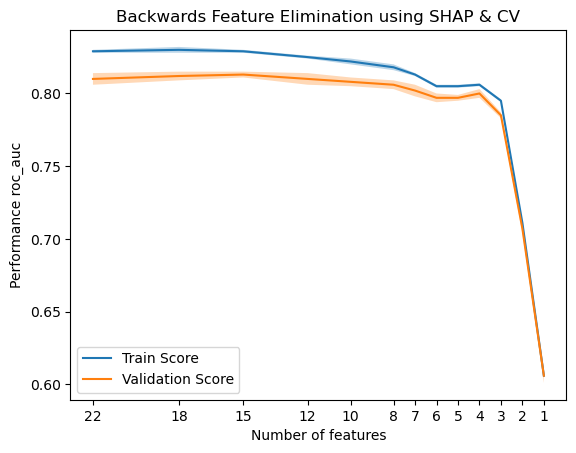

In [8]:
# Alternate method for larger datasets : Run feature elimination
shap_elimination = ShapRFECV(search_roc_auc, step=0.2, cv=5, scoring='roc_auc', n_jobs=4)
report = shap_elimination.fit_compute(X_train, y_train,check_additivity=False)
performance_plot = shap_elimination.plot()

In [9]:
#Display feature extracted vs. performance report 
report[['num_features', 'features_set', 'val_metric_mean']]

,num_features,features_set,val_metric_mean
1,22,"[income, debt_to_income_ratio, combined_loan_t...",0.810
2,18,"[loan_type, tract_minority_population_percent,...",0.812
3,15,"[tract_minority_population_percent, loan_type,...",0.813
4,12,"[derived_race, debt_to_income_ratio, property_...",0.810
5,10,"[debt_to_income_ratio, property_value, combine...",0.808
6,8,"[debt_to_income_ratio, property_value, combine...",0.806
7,7,"[debt_to_income_ratio, property_value, county_...",0.802
8,6,"[debt_to_income_ratio, property_value, preappr...",0.797
9,5,"[debt_to_income_ratio, property_value, preappr...",0.797
10,4,"[preapproval, debt_to_income_ratio, property_v...",0.800


In [10]:
# Get final feature set
final_features_set = shap_elimination.get_reduced_features_set(num_features=10)

search_roc_auc.fit(X_train, y_train)
print("Best set of Hyperparameters:")
print(search_roc_auc.best_params_)

print("Top features: ", final_features_set)

Best set of Hyperparameters:
{'min_samples_leaf': 7, 'max_depth': 7}
Top features:  ['debt_to_income_ratio', 'property_value', 'combined_loan_to_value_ratio', 'county_code', 'preapproval', 'loan_amount', 'loan_purpose', 'ffiec_msa_md_median_family_income', 'applicant_age', 'income']


In [11]:
# Get final feature set
final_features_set = shap_elimination.get_reduced_features_set(num_features=18)

search_roc_auc.fit(X_train, y_train)
print("Best set of Hyperparameters:")
print(search_roc_auc.best_params_)

print("Top features: ", final_features_set)

Best set of Hyperparameters:
{'min_samples_leaf': 7, 'max_depth': 7}
Top features:  ['loan_type', 'tract_minority_population_percent', 'tract_median_age_of_housing_units', 'income', 'county_code', 'loan_term', 'loan_amount', 'derived_race', 'tract_to_msa_income_percentage', 'ffiec_msa_md_median_family_income', 'applicant_age', 'derived_sex', 'debt_to_income_ratio', 'property_value', 'combined_loan_to_value_ratio', 'preapproval', 'loan_purpose', 'state_code']


In [22]:
# Get final feature set
for i in range(1,22):
    final_features_set = shap_elimination.get_reduced_features_set(num_features=i)
    search_roc_auc.fit(X_train, y_train)    
    print("Hyperparameters:")
    print(search_roc_auc.best_params_)
    print("No. of Features: ",i)
    print("Features: ", final_features_set)

The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.


Hyperparameters:
{'reg_lambda': 1.0, 'reg_alpha': 0.1, 'min_child_weight': 0.5, 'max_depth': 5, 'colsample_bylevel': 0.5}
No. of Features:  1
Features:  ['preapproval']


The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.


Hyperparameters:
{'reg_lambda': 1.0, 'reg_alpha': 0.1, 'min_child_weight': 0.5, 'max_depth': 5, 'colsample_bylevel': 0.5}
No. of Features:  2
Features:  ['preapproval', 'debt_to_income_ratio']


The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.


Hyperparameters:
{'reg_lambda': 1.0, 'reg_alpha': 0.1, 'min_child_weight': 0.5, 'max_depth': 5, 'colsample_bylevel': 0.5}
No. of Features:  3
Features:  ['preapproval', 'debt_to_income_ratio', 'loan_purpose']


The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.


Hyperparameters:
{'reg_lambda': 1.0, 'reg_alpha': 0.1, 'min_child_weight': 0.5, 'max_depth': 5, 'colsample_bylevel': 0.5}
No. of Features:  4
Features:  ['preapproval', 'debt_to_income_ratio', 'property_value', 'loan_purpose']


The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.


Hyperparameters:
{'reg_lambda': 1.0, 'reg_alpha': 0.1, 'min_child_weight': 0.5, 'max_depth': 5, 'colsample_bylevel': 0.5}
No. of Features:  5
Features:  ['debt_to_income_ratio', 'property_value', 'county_code', 'preapproval', 'loan_purpose']


The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.


Hyperparameters:
{'reg_lambda': 1.0, 'reg_alpha': 0.1, 'min_child_weight': 0.5, 'max_depth': 5, 'colsample_bylevel': 0.5}
No. of Features:  6
Features:  ['debt_to_income_ratio', 'property_value', 'combined_loan_to_value_ratio', 'county_code', 'preapproval', 'loan_purpose']


The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.


Hyperparameters:
{'reg_lambda': 1.0, 'reg_alpha': 0.1, 'min_child_weight': 0.5, 'max_depth': 5, 'colsample_bylevel': 0.5}
No. of Features:  7
Features:  ['debt_to_income_ratio', 'property_value', 'combined_loan_to_value_ratio', 'county_code', 'preapproval', 'loan_purpose', 'state_code']


The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.


Hyperparameters:
{'reg_lambda': 1.0, 'reg_alpha': 0.1, 'min_child_weight': 0.5, 'max_depth': 5, 'colsample_bylevel': 0.5}
No. of Features:  8
Features:  ['debt_to_income_ratio', 'property_value', 'combined_loan_to_value_ratio', 'county_code', 'preapproval', 'loan_purpose', 'loan_amount', 'state_code']


ValueError: The provided number of features has not been achieved at any stage of the process. You can select one of the following: [22, 18, 15, 12, 10, 8, 7, 6, 5, 4, 3, 2, 1]

In [23]:
# Get final feature set
final_features_set = shap_elimination.get_reduced_features_set(num_features=10)
search_roc_auc.fit(X_train, y_train)    
print("Hyperparameters:")
print(search_roc_auc.best_params_)
print("No. of Features: ",10)
print("Features: ", final_features_set)

The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.


Hyperparameters:
{'reg_lambda': 1.0, 'reg_alpha': 0.1, 'min_child_weight': 0.5, 'max_depth': 5, 'colsample_bylevel': 0.5}
No. of Features:  10
Features:  ['debt_to_income_ratio', 'loan_type', 'property_value', 'state_code', 'combined_loan_to_value_ratio', 'county_code', 'preapproval', 'loan_amount', 'loan_purpose', 'income']


In [24]:
# Get final feature set
final_features_set = shap_elimination.get_reduced_features_set(num_features=12)
search_roc_auc.fit(X_train, y_train)    
print("Hyperparameters:")
print(search_roc_auc.best_params_)
print("No. of Features: ",12)
print("Features: ", final_features_set)

The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.


Hyperparameters:
{'reg_lambda': 1.0, 'reg_alpha': 0.1, 'min_child_weight': 0.5, 'max_depth': 5, 'colsample_bylevel': 0.5}
No. of Features:  12
Features:  ['derived_race', 'debt_to_income_ratio', 'loan_type', 'property_value', 'income', 'combined_loan_to_value_ratio', 'county_code', 'preapproval', 'loan_purpose', 'loan_amount', 'applicant_age', 'state_code']


In [25]:
# Get final feature set
final_features_set = shap_elimination.get_reduced_features_set(num_features=15)
search_roc_auc.fit(X_train, y_train)    
print("Hyperparameters:")
print(search_roc_auc.best_params_)
print("No. of Features: ",15)
print("Features: ", final_features_set)

The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.


Hyperparameters:
{'reg_lambda': 1.0, 'reg_alpha': 0.1, 'min_child_weight': 0.5, 'max_depth': 5, 'colsample_bylevel': 0.5}
No. of Features:  15
Features:  ['tract_minority_population_percent', 'loan_type', 'income', 'county_code', 'loan_term', 'derived_race', 'ffiec_msa_md_median_family_income', 'loan_amount', 'applicant_age', 'debt_to_income_ratio', 'property_value', 'combined_loan_to_value_ratio', 'preapproval', 'loan_purpose', 'state_code']


In [26]:
# Get final feature set
final_features_set = shap_elimination.get_reduced_features_set(num_features=18)
search_roc_auc.fit(X_train, y_train)    
print("Hyperparameters:")
print(search_roc_auc.best_params_)
print("No. of Features: ",18)
print("Features: ", final_features_set)

The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.


Hyperparameters:
{'reg_lambda': 1.0, 'reg_alpha': 0.1, 'min_child_weight': 0.5, 'max_depth': 5, 'colsample_bylevel': 0.5}
No. of Features:  18
Features:  ['loan_type', 'tract_minority_population_percent', 'tract_median_age_of_housing_units', 'income', 'county_code', 'loan_term', 'tract_population', 'loan_amount', 'derived_race', 'tract_to_msa_income_percentage', 'ffiec_msa_md_median_family_income', 'applicant_age', 'debt_to_income_ratio', 'property_value', 'combined_loan_to_value_ratio', 'preapproval', 'loan_purpose', 'state_code']


In [27]:
# Get final feature set
final_features_set = shap_elimination.get_reduced_features_set(num_features=22)
search_roc_auc.fit(X_train, y_train)    
print("Hyperparameters:")
print(search_roc_auc.best_params_)
print("No. of Features: ",22)
print("Features: ", final_features_set)

The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.


Hyperparameters:
{'reg_lambda': 1.0, 'reg_alpha': 0.1, 'min_child_weight': 0.5, 'max_depth': 5, 'colsample_bylevel': 0.5}
No. of Features:  22
Features:  ['income', 'debt_to_income_ratio', 'combined_loan_to_value_ratio', 'loan_amount', 'derived_ethnicity', 'derived_race', 'derived_sex', 'applicant_age', 'preapproval', 'loan_type', 'loan_purpose', 'interest_only_payment', 'balloon_payment', 'loan_term', 'property_value', 'state_code', 'county_code', 'tract_minority_population_percent', 'tract_population', 'tract_to_msa_income_percentage', 'tract_median_age_of_housing_units', 'ffiec_msa_md_median_family_income']


#### Visualize RFE for metric Recall

In [ ]:
# Alternate method for larger datasets : Run feature elimination
shap_elimination = ShapRFECV(search_recall, step=0.2, cv=5, scoring='recall', n_jobs=4,check_additivity=False)
report = shap_elimination.fit_compute(X_train, y_train)
performance_plot = shap_elimination.plot()

In [ ]:
#Display feature extracted vs. performance report 
report[['num_features', 'features_set', 'val_metric_mean']]

In [ ]:
# Get final feature set
final_features_set = shap_elimination.get_reduced_features_set(num_features=15)

search_recall.fit(X_train, y_train)
print("Best set of Hyperparameters:")
print(search_recall.best_params_)

print("Top features: ", final_features_set)

### XGBoost Classifier
In this section we set up the hyperparameter grid to use XGBoost classifier to determine the most influential features in terms of performance.

In [13]:
x_clf = XGBClassifier(random_state=42)
param_grid = {
    'colsample_bylevel':[0.5],
    'max_depth': [3,5,7],
    'min_child_weight': [0.5],
    #'n_estimators': [100],
    'reg_alpha': [0.1], 
    'reg_lambda': [1.0]
}

search_roc_auc = RandomizedSearchCV(x_clf, param_grid, cv=5, scoring='roc_auc', refit=False)
#search_prec = RandomizedSearchCV(x_clf, param_grid, cv=5, scoring='precision', refit=False)
search_recall = RandomizedSearchCV(x_clf, param_grid, cv=5, scoring='recall', refit=False)
print("Hyperparameter search complete")

Hyperparameter search complete


#### Visualize RFE for metric ROC

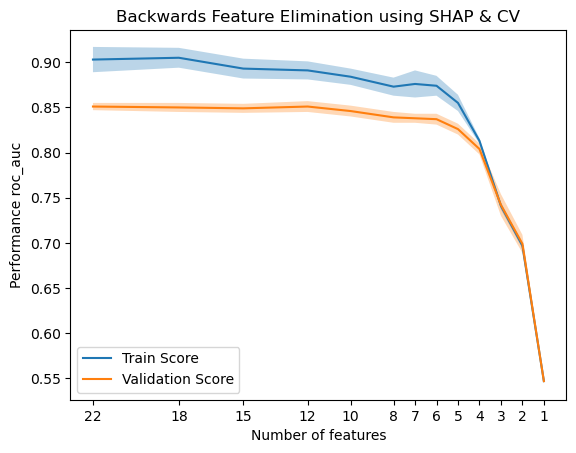

In [14]:
# Run feature elimination
shap_elimination = EarlyStoppingShapRFECV(
    clf=x_clf, step=0.2, cv=10, scoring='roc_auc', early_stopping_rounds=10, n_jobs=3)
report = shap_elimination.fit_compute(X_train, y_train, check_additivity=False)

# Make plots
performance_plot = shap_elimination.plot()

In [15]:
#Display feature extracted vs. performance report 
report[['num_features', 'features_set', 'val_metric_mean']]

,num_features,features_set,val_metric_mean
1,22,"[income, debt_to_income_ratio, combined_loan_t...",0.851
2,18,"[loan_type, tract_minority_population_percent,...",0.850
3,15,"[tract_minority_population_percent, loan_type,...",0.849
4,12,"[derived_race, debt_to_income_ratio, loan_type...",0.851
5,10,"[debt_to_income_ratio, loan_type, property_val...",0.846
6,8,"[debt_to_income_ratio, property_value, combine...",0.839
7,7,"[debt_to_income_ratio, property_value, combine...",0.838
8,6,"[debt_to_income_ratio, property_value, combine...",0.837
9,5,"[debt_to_income_ratio, property_value, county_...",0.826
10,4,"[preapproval, debt_to_income_ratio, property_v...",0.804


In [16]:
# Get final feature set
final_features_set = shap_elimination.get_reduced_features_set(num_features=15)

In [17]:
search_roc_auc.fit(X_train, y_train)
print("Best set of Hyperparameters:")
print(search_roc_auc.best_params_)
print("Top features: ", final_features_set)

The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.


Best set of Hyperparameters:
{'reg_lambda': 1.0, 'reg_alpha': 0.1, 'min_child_weight': 0.5, 'max_depth': 5, 'colsample_bylevel': 0.5}
Top features:  ['tract_minority_population_percent', 'loan_type', 'income', 'county_code', 'loan_term', 'derived_race', 'ffiec_msa_md_median_family_income', 'loan_amount', 'applicant_age', 'debt_to_income_ratio', 'property_value', 'combined_loan_to_value_ratio', 'preapproval', 'loan_purpose', 'state_code']


#### Visualize RFE for metric recall

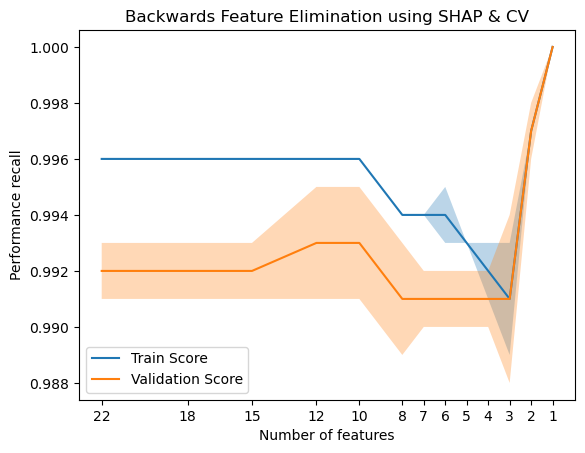

In [18]:
# Run feature elimination
shap_elimination = EarlyStoppingShapRFECV(
    clf=x_clf, step=0.2, cv=10, scoring='recall', early_stopping_rounds=10, n_jobs=3)
report = shap_elimination.fit_compute(X_train._get_numeric_data(), y_train, check_additivity=False)

# Make plots
performance_plot = shap_elimination.plot()

# Get final feature set
final_features_set = shap_elimination.get_reduced_features_set(num_features=3)

In [19]:
#Display feature extracted vs. performance report 
report[['num_features', 'features_set', 'val_metric_mean']]

,num_features,features_set,val_metric_mean
1,22,"[income, debt_to_income_ratio, combined_loan_t...",0.992
2,18,"[loan_type, tract_minority_population_percent,...",0.992
3,15,"[tract_minority_population_percent, loan_type,...",0.992
4,12,"[derived_race, debt_to_income_ratio, loan_type...",0.993
5,10,"[debt_to_income_ratio, loan_type, property_val...",0.993
6,8,"[debt_to_income_ratio, property_value, combine...",0.991
7,7,"[debt_to_income_ratio, property_value, combine...",0.991
8,6,"[debt_to_income_ratio, property_value, combine...",0.991
9,5,"[debt_to_income_ratio, property_value, county_...",0.991
10,4,"[preapproval, debt_to_income_ratio, property_v...",0.991


In [20]:
search_recall.fit(X_train._get_numeric_data(), y_train)
print("Best set of Hyperparameters:")
print(search_recall.best_params_)

print("Top features: ", final_features_set)

The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.


Best set of Hyperparameters:
{'reg_lambda': 1.0, 'reg_alpha': 0.1, 'min_child_weight': 0.5, 'max_depth': 3, 'colsample_bylevel': 0.5}
Top features:  ['preapproval', 'debt_to_income_ratio', 'loan_purpose']
